# 1. Script set-up

In [799]:
# Download libraries
import requests
from bs4 import BeautifulSoup
import time
from random import randint
import numpy as np
import urllib3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [800]:
# Appears to be required to avoid warnings for MM security
urllib3.disable_warnings()

# 2. List of tunnels from Wikipedia

## 2.1. Webscraping

In [801]:
# first pull the HTML from the page. This is pulling from a wikipedia page (and later links off this page)
html = requests.get('https://en.wikipedia.org/wiki/List_of_tunnels_in_the_United_Kingdom',verify=False)

# turn the HTML into a beautiful soup text object
b = BeautifulSoup(html.text, features='lxml')

In [802]:
# Empty lists that the webscraping will add to
tunnel_names = []
tunnel_links = []
tunnel_types = []
tunnel_lengths =[]
opening_dates = []

# Information stored in tables under a class tag. Then require getting the rows (<tr>), then cells in the row (<td>).
for table in b.find_all(name='table', class_='wikitable'):
    #'tr'/row contains each row in info table
    for row in table.find(name='tbody').find_all(name='tr')[1:]: #Head of the table seems to get included in tbody...
        #'td' contains each cell in row
        cells=row.find_all(name='td')
        
        #1. Tunnel name
        tunnel_names.append(cells[1].get_text())
        
        #2. Tunnel link
        if len(cells[1].find_all(name='a')) > 0:
            tunnel_links.append(cells[1].find_all(name='a')[0].get('href'))
        else:
            tunnel_links.append('No link')
        
        #3. Tunnel type
        tunnel_types.append(cells[2].get_text())
        
        #4. Tunnel length
        tunnel_lengths.append(cells[3].get_text())
        
        #5. Tunnel opening date
        opening_dates.append(cells[6].get_text())

#Concatinate them into dataframe
df = pd.concat([pd.Series(tunnel_names),pd.Series(tunnel_links),pd.Series(tunnel_types),pd.Series(tunnel_lengths),pd.Series(opening_dates)],axis=1)  

## 2.2. Analysing and cleaning data

In [803]:
# Add column names
df.columns = ['TunnelName','WikiLink','TunnelType','Length[m]','OpeningDate']
df.head(5)

,TunnelName,WikiLink,TunnelType,Length[m],OpeningDate
0,Ampthill Tunnel,/wiki/Ampthill_Tunnel,Railway,654,1859
1,Linslade Tunnel,/wiki/Linslade_Tunnel,Railway,249,"1837, 1859, 1876"
2,Old Warden Tunnel,/wiki/Old_Warden_Tunnel,Railway,807,1853
3,Wymington Tunnel,/w/index.php?title=Wymington_Tunnel&action=edi...,Railway,"1,690",1859
4,Clifton Down Tunnel,/wiki/Clifton_Down_Tunnel,Railway,"1,601",1874


In [804]:
# Some data cleaning

#Replace \n
df = df.replace(to_replace='\n',value="",regex=True)
#Replace non-wiki links
df.loc[~df.WikiLink.str.contains('/wiki/'),'WikiLink']='No link'
df.loc[df.WikiLink.str.contains('https://'),'WikiLink']='No link'
#Replace ...
df.OpeningDate = df.OpeningDate.replace(to_replace=r'^\s*$',value="Unknown",regex=True)
#Convert length to numeric
df['Length[m]'] = df['Length[m]'].apply(lambda x: x.split('[')[0] if '[' in x else x)
df['Length[m]'] = df['Length[m]'].str.replace(',','')
df['Length[m]'] = pd.to_numeric(df['Length[m]'])
# replace field that's entirely space (or empty) with 'Unknown'
df.replace(r'^\s*$', 'Unknown', regex=True,inplace=True)

C:\Users\hei79524\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Text(0.5, 1, 'Unknown values')

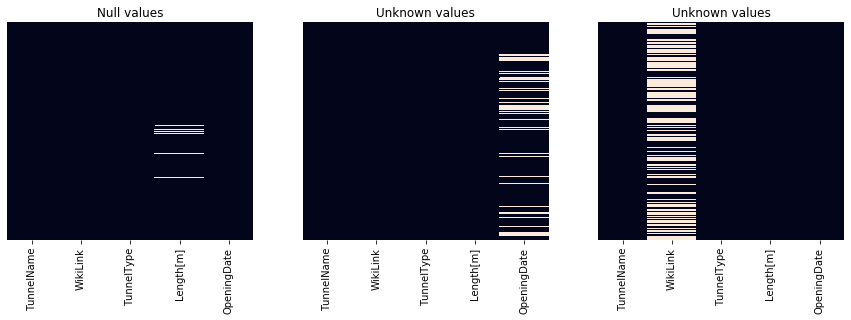

In [805]:
#Look for missing data

#Initialise figure and ax
plt.figure(figsize=[15,4])

#Create plot
plt.subplot(1,3,1)
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)
plt.title('Null values')

plt.subplot(1,3,2)
sns.heatmap(df==('Unknown') ,yticklabels=False,cbar=False)
plt.title('Unknown values')

plt.subplot(1,3,3)
sns.heatmap(df==('No link') ,yticklabels=False,cbar=False)
plt.title('No link')

In [819]:
print("Tunnels that can be mapped: "+"{:.1%}".format(df.WikiLink.loc[df.WikiLink!='No link'].count()/df.WikiLink.count()))

Tunnels that can be mapped: 48.2%


Note:
- Only a few lengths are missing so this is okay.
- OpeningDate isn't used anywhere other than providing further information for interest so this is okay.
- Unfortunately, any tunnel missing a 'WikiLink' will not be shown in the final graph as no location co-ordinate can be found. This is quite a lot of tunnels, however, tunnels without a link (wikipedia page) are far more likely to be minor tunnels and therefore not as useful for what we do.

Text(0.5, 1.0, 'Tunnel length distribution - zoomed in')

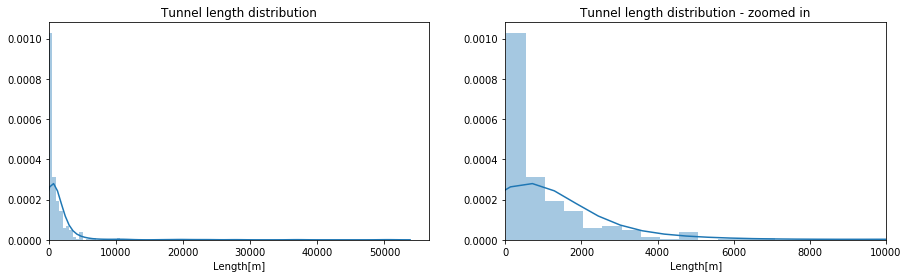

In [820]:
# Looking at the distribution of tunnel lengths

#Initialise figure and ax
plt.figure(figsize=[15,4])

#Create plot
plt.subplot(1,2,1)
sns.distplot(df['Length[m]'].dropna(),kde=True,bins=100)
plt.xlim(0)
plt.title('Tunnel length distribution')

plt.subplot(1,2,2)
sns.distplot(df['Length[m]'].dropna(),kde=True,bins=100)
plt.xlim(0,10000)
plt.title('Tunnel length distribution - zoomed in')

# 3. Geographical co-ordinates for each tunnel

## 3.1. Webscraping

In [807]:
# Add co-ordinates by getting the HTML code from each tunnel link

#Lists to be ammended (must add up to length of df for merging)
latitude =[]
longitude = []

#Operation takes a while so start/complete is useful to check it's running
print('Started')

#Get coordinates (if exist)
for link_end in df.WikiLink:
    if link_end == 'No link':
        latitude.append(float('nan'))
        longitude.append(float('nan'))
    else:
        page_html = requests.get('https://en.wikipedia.org' + link_end,verify=False)
        page_soup = BeautifulSoup(page_html.text, features='lxml')        
        #len() required to avoid errors if don't exist
        if len(page_soup.find_all(name='span', class_='latitude')) > 0:
            #Structure of website has the required co-ordinates at the top of the page so [0] prevents any errors from a list
            latitude.append(page_soup.find_all(name='span', class_='latitude')[0].get_text())
            longitude.append(page_soup.find_all(name='span', class_='longitude')[0].get_text())
        #If for any reason co-ordinates are not on a page, this captures that eventuality
        else:
            latitude.append(float('nan'))
            longitude.append(float('nan'))            
    #Good practice to slow down/ randomise requests
    time.sleep(randint(1,100)/100)
    
#Convert to series and add to df
df['Latitude']=pd.Series(latitude)
df['Longitude']=pd.Series(longitude)

print('Complete')

Started
Complete


## 3.2. Analysing and cleaning data 2

In [808]:
df.head(5)

,TunnelName,WikiLink,TunnelType,Length[m],OpeningDate,Latitude,Longitude
0,Ampthill Tunnel,/wiki/Ampthill_Tunnel,Railway,654.0,1859,52°02′01″N,0°30′48″W
1,Linslade Tunnel,/wiki/Linslade_Tunnel,Railway,249.0,"1837, 1859, 1876",51°55′31″N,0°40′35″W
2,Old Warden Tunnel,/wiki/Old_Warden_Tunnel,Railway,807.0,1853,52°05′18″N,0°22′33″W
3,Wymington Tunnel,No link,Railway,1690.0,1859,NaN,NaN
4,Clifton Down Tunnel,/wiki/Clifton_Down_Tunnel,Railway,1601.0,1874,51°28′10″N,2°37′08″W


In [809]:
# This converts the latitude and longitude values into the correct format for mapping.

def geo_direction(text):
    '''Calculate Decimal Degrees from Degrees Minutes Seconds (DMS)'''
    if type(text) is str:
        try:
            degrees_input = float(text.split('°')[0])
            minutes = float(text.split('°')[1].split('′')[0])
            seconds = float(text.split('°')[1].split('′')[1].split('″')[0])
            direction = text.split('°')[1].split('′')[1].split('″')[1]
        
            degrees_output = degrees_input + minutes/60 + seconds/3600
        
            if direction == 'S':
                return degrees_output * (-1)
            elif direction == 'W':
                return degrees_output * (-1)    
            else:
                return degrees_output 
        except:
            return float('nan')
    else:
        return float('nan')

#Columns to apply function to
cols = ['Latitude','Longitude']
for col in cols:
    df[col] = df[col].apply(geo_direction)
    df[col] = pd.to_numeric(df[col])

In [810]:
df.head(5)

,TunnelName,WikiLink,TunnelType,Length[m],OpeningDate,Latitude,Longitude
0,Ampthill Tunnel,/wiki/Ampthill_Tunnel,Railway,654.0,1859,52.033611,-0.513333
1,Linslade Tunnel,/wiki/Linslade_Tunnel,Railway,249.0,"1837, 1859, 1876",51.925278,-0.676389
2,Old Warden Tunnel,/wiki/Old_Warden_Tunnel,Railway,807.0,1853,52.088333,-0.375833
3,Wymington Tunnel,No link,Railway,1690.0,1859,NaN,NaN
4,Clifton Down Tunnel,/wiki/Clifton_Down_Tunnel,Railway,1601.0,1874,51.469444,-2.618889


# 4. Export output

In [811]:
#Export cleaned tunnel list
df.to_csv('tunnels_list.csv', index=False)